# TASK: build rec sys :=)

data downloaded from https://nijianmo.github.io/amazon/index.html, chapter is '"Small" subsets for experimentation', named 'Video Games', based on ratings


In [1]:
import json
import pandas as pd
import surprise
import matplotlib.pyplot as plt
import random
import scipy.sparse as sparse
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.base import BaseEstimator
import optuna
from sklearn.metrics import mean_absolute_error, mean_squared_error

## loading

In [2]:
data = pd.read_csv('./data/data.csv', header=None, names=['item_id', 'user_id', 'rating', 'timestamp'])
data = data.sort_values(by=['user_id', 'timestamp'])
data

,item_id,user_id,rating,timestamp
350131,B01617VNBK,A00577669P2XCLU956L8,5.0,1454198400
262198,B00MCLGAZ4,A00621707WIM8QF2CT5O,5.0,1412640000
301851,B00SX73LIK,A0065811S4ANKB4TYHII,5.0,1424908800
360077,B019QVZDSC,A0086201G57OY58MG97W,4.0,1458172800
428464,B007A7JSMM,A0086201G57OY58MG97W,4.0,1458259200
...,...,...,...,...
10245,B000069VAW,AZZXPJXXADPD2,1.0,1040169600
452063,B00WFH8NOQ,AZZXVOQ8ZYK9P,5.0,1453680000
6915,B00005LBVS,AZZY4E6QPTBVP,4.0,1445472000
171032,B00B5P23SG,AZZYTPFG6JF1K,2.0,1377043200


In [3]:
user_list = data['user_id'].unique()
item_list = data['item_id'].unique()

cols = data['item_id'].astype('category').cat.codes 
rows = data['user_id'].astype('category').cat.codes 

sparse_df = sparse.csr_matrix((data['rating'], (rows, cols)), shape=(len(user_list), len(item_list)))
print(type(sparse_df))
sparse_df

<class 'scipy.sparse._csr.csr_matrix'>


<375147x21663 sparse matrix of type '<class 'numpy.float64'>'
	with 450578 stored elements in Compressed Sparse Row format>

## EDA

In [4]:
matrix_size = sparse_df.shape[0]*sparse_df.shape[1] # Number of values in the matrix
non_zeroes_size = len(sparse_df.nonzero()[0]) # Number of non-zeroes with
sparsity = 100*(1 - (non_zeroes_size/matrix_size))
sparsity

99.99445565935609

In [10]:
data.describe()['rating']

count    2.565349e+06
mean     4.022095e+00
std      1.405936e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

more than halve are 5

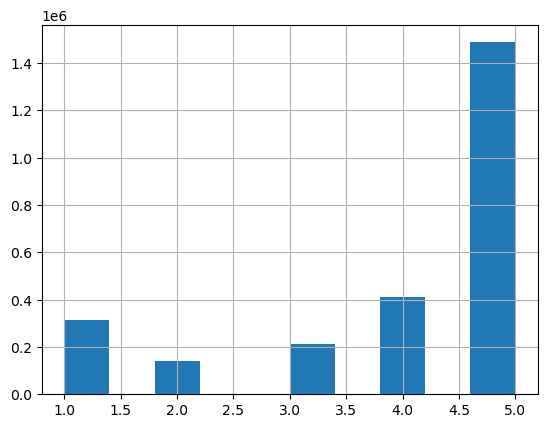

In [11]:
data['rating'].hist()

In [12]:
grouped_user = data.groupby('user_id').agg({'rating': ['min', 'max', 'mean', 'count']})

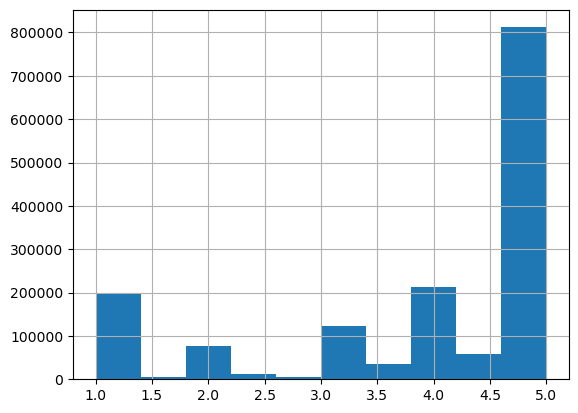

In [13]:
grouped_user['rating']['mean'].hist()

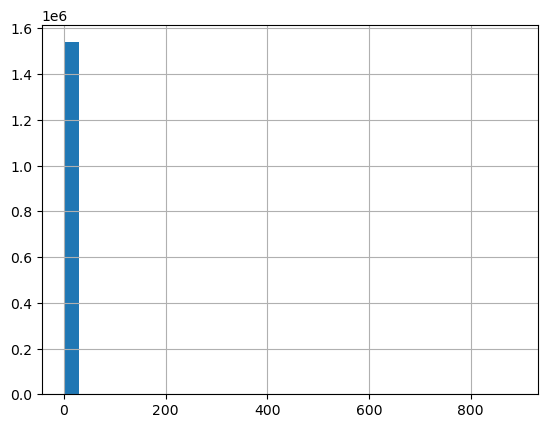

In [14]:
grouped_user['rating']['count'].hist(bins=30)

In [15]:
grouped_user['rating']['count'].value_counts()

count
1      1127396
2       232295
3        79972
4        36868
5        19842
        ...   
115          1
512          1
139          1
641          1
256          1
Name: count, Length: 159, dtype: int64

In [16]:
grouped_item = data.groupby('item_id').agg({'rating': ['min', 'max', 'mean', 'count']})

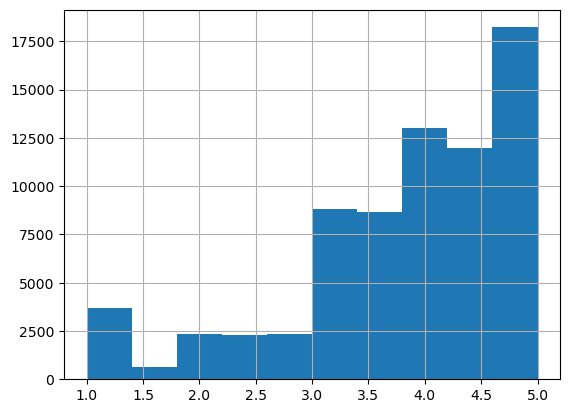

In [17]:
grouped_item['rating']['mean'].hist()

## prepaire surprise.dataset

In [4]:
# don't want to split randomly like here.
# reader = surprise.Reader(line_format='item user rating',
#                          rating_scale=(1, 5))

# dataset = surprise.Dataset.load_from_df(data[['item_id', 'user_id', 'rating']], reader)

# trainset, testset = surprise.model_selection.train_test_split(dataset, test_size=0.2, random_state=42)

# trainset

In [5]:
test_size = 0.2

data = data.sort_values(by='timestamp').reset_index(drop=True)
train_df = data.iloc[:int((1-test_size)*data.shape[0])]
test_df = data.iloc[int((1-test_size)*data.shape[0]):]  # I don't want to get in test last ratings by each users
                                                        # cause in real situation we will have a new user and item

print(f'Train_size: {train_df.shape[0]}, Test_size: {test_df.shape[0]}')
reader = surprise.Reader(line_format='item user rating',
                         rating_scale=(1, 5))

trainset = surprise.Dataset.load_from_df(train_df[['item_id', 'user_id', 'rating']], reader)

testset = surprise.Dataset.load_from_df(test_df[['item_id', 'user_id', 'rating']], reader)
_, testset = surprise.model_selection.train_test_split(testset, test_size=1.0)

Train_size: 367548, Test_size: 91888


In [6]:
def get_best_params_with_optuna(dataset,
                          common_params,
                          max_evals,
                          param_space,
                          surprise_class: surprise.prediction_algorithms,
                          measure: str,
                          cv: int = 5,
                          optuna_algorithm: str = 'tpe',
                          train_verbose: bool = False,
                          **kwargs):
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    
    sampler = {
        'tpe': optuna.samplers.TPESampler,
        'grid': optuna.samplers.GridSampler,
        'random': optuna.samplers.RandomSampler,
    }[optuna_algorithm]
    study = optuna.create_study(direction="maximize", sampler=sampler(),
                                pruner=optuna.pruners.HyperbandPruner() if optuna_algorithm == 'tpe' else optuna.pruners.MedianPruner())
    
    def objective(trial):
        params = {**common_params}
        for suggestion in param_space.keys():
            if suggestion in ('suggest_float', 'suggest_int'):
                for hp in param_space[suggestion]:
                    params[hp] = getattr(trial, suggestion)(hp, param_space[suggestion][hp][0], param_space[suggestion][hp][1])
            elif suggestion in ('suggest_categorical'):
                for hp in param_space[suggestion]:
                    params[hp] = getattr(trial, suggestion)(hp, param_space[suggestion][hp])
        surprise_instance = surprise_class(**params)
        acc = surprise.model_selection.cross_validate(surprise_instance, dataset,
                                                      measures=[measure], cv=cv, verbose=train_verbose)
        acc = acc[f'test_{measure.lower()}'].mean()
        
        return acc
    
    study.optimize(objective, n_trials=max_evals, show_progress_bar=True)        
    
    res_tun = {**common_params, **study.best_params}
                                
    return res_tun

## SVD

In [6]:
curr_params = {
    "max_evals": 40,
    "measure": 'RMSE',
    "cv": 5,
    "common_params": {
        "random_state": 42,
    },
    "param_space": {
        "suggest_float": {
            "lr_all": [0.001, 0.1],
            "reg_all": [0.001, 3],
        },
        "suggest_int": {
            "n_epochs": [5, 100],
            "n_factors": [2, 20],
        },
    }
    
}

In [7]:
curr_surprise_alg = surprise.SVD
best_params_for_SVD = get_best_params_with_optuna(trainset,
                                                  surprise_class=curr_surprise_alg,
                                                  **curr_params)
best_params_for_SVD

  0%|          | 0/40 [00:00<?, ?it/s]

{'random_state': 42,
 'lr_all': 0.0013374491824391724,
 'reg_all': 2.982215985857193,
 'n_epochs': 22,
 'n_factors': 4}

In [8]:
SVD_best_conf = curr_surprise_alg(**best_params_for_SVD)
SVD_best_conf = SVD_best_conf.fit(trainset.build_full_trainset())

In [9]:
predictions = SVD_best_conf.test(testset)
surprise.accuracy.rmse(predictions)

RMSE: 1.6230


1.6229875851691324

## SVD++

In [13]:
curr_params = {
    "max_evals": 5,
    "measure": 'RMSE',
    "cv": 5,
    "common_params": {
        "random_state": 42,
        "cache_ratings": True,
        "lr_all": 0.001
    },
    "param_space": {
        "suggest_float": {
            "reg_all": [0.1, 30],
        },
        "suggest_int": {
            "n_epochs": [50, 100],
            "n_factors": [2, 20],
        },
#         "suggest_categorical": {
#             'cache_ratings': [True, False]
#         },
    }
    
}

In [9]:
curr_surprise_alg = surprise.SVDpp

In [14]:
%%time
best_params_for_SVDpp = get_best_params_with_optuna(trainset,
                                                    surprise_class=curr_surprise_alg,
                                                    **curr_params)
best_params_for_SVDpp

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 3h 45min 11s, sys: 2.17 s, total: 3h 45min 13s
Wall time: 3h 45min 17s


{'random_state': 42,
 'cache_ratings': True,
 'lr_all': 0.001,
 'reg_all': 28.624607344463232,
 'n_epochs': 81,
 'n_factors': 15}

In [10]:
SVDpp_best_conf = curr_surprise_alg(**best_params_for_SVDpp)
SVDpp_best_conf = SVDpp_best_conf.fit(trainset.build_full_trainset())

In [11]:
predictions = SVDpp_best_conf.test(testset)
surprise.accuracy.rmse(predictions)

RMSE: 1.6476


1.6475660344302538

## kNN

In [27]:
curr_params = {
    "max_evals": 40,
    "measure": 'RMSE',
    "cv": 5,
    "common_params": {
        "random_state": 42,
        "name": 'cosine',
        "verbose": False,
    },
    "param_space": {
        "suggest_int": {
            "k": [5, 30],
            "min_k": [2, 20],
        },
        "suggest_categorical": {
            'user_based': [True, False]
        }
    }
}

In [28]:
curr_surprise_alg = surprise.KNNBaseline
best_params_for_kNN = get_best_params_with_optuna(trainset,
                                                  surprise_class=curr_surprise_alg,
                                                  **curr_params)

  0%|          | 0/40 [00:00<?, ?it/s]

In [29]:
best_params_for_kNN

{'random_state': 42,
 'name': 'cosine',
 'verbose': False,
 'k': 30,
 'min_k': 15,
 'user_based': True}

In [30]:
kNN_best_conf = curr_surprise_alg(**best_params_for_kNN)
kNN_best_conf = kNN_best_conf.fit(trainset.build_full_trainset())

In [31]:
predictions = kNN_best_conf.test(testset)
surprise.accuracy.rmse(predictions)

RMSE: 1.5982


1.598165876316985

## Slope One

In [ ]:
## It havn't worked bacause of RAM
# so1 = surprise.SlopeOne()

# sol_instance = so1.fit(trainset.build_full_trainset())

# predictions = sol_instance.test(testset)
# surprise.accuracy.rmse(predictions)

## Co-clustering

In [9]:
curr_params = {
    "max_evals": 20,
    "cv": 5,
    "measure": 'RMSE',
    "common_params": {
        "random_state": 42
    },
    "param_space": {
        "suggest_int": {
            "n_cltr_u": [2, 30],
            "n_cltr_i": [2, 30],
            "n_epochs": [10, 50]
        }
    }
}

In [10]:
curr_surprise_alg = surprise.CoClustering
best_params_for_CoC = get_best_params_with_optuna(trainset,
                                                  surprise_class=curr_surprise_alg,
                                                  **curr_params)
best_params_for_CoC

  0%|          | 0/20 [00:00<?, ?it/s]

{'random_state': 42, 'n_cltr_u': 13, 'n_cltr_i': 2, 'n_epochs': 11}

In [11]:
CoC_best_conf = curr_surprise_alg(**best_params_for_CoC)
CoC_best_conf = CoC_best_conf.fit(trainset.build_full_trainset())

In [12]:
predictions = CoC_best_conf.test(testset)
surprise.accuracy.rmse(predictions)

RMSE: 1.6544


1.654435092622388

## NMF

In [7]:
curr_params = {
    "max_evals": 25,
    "measure": 'RMSE',
    "cv": 5,
    "common_params": {
        "random_state": 42,
        "biased": True,
    },
    "param_space": {
        "suggest_float": {
            "lr_bu": [0.001, 0.1],
            "lr_bi": [0.001, 0.1],
            "reg_pu": [0.001, 3],
            "reg_bu": [0.001, 3],
            "reg_qi": [0.001, 3],
            "reg_bi": [0.001, 3],
        },
        "suggest_int": {
            "n_epochs": [5, 100],
            "n_factors": [2, 20],
        },
    }
    
}

In [8]:
curr_surprise_alg = surprise.NMF
best_params_for_NMF = get_best_params_with_optuna(trainset,
                                                  surprise_class=curr_surprise_alg,
                                                  **curr_params)
best_params_for_NMF

  0%|          | 0/25 [00:00<?, ?it/s]

{'random_state': 42,
 'biased': True,
 'lr_bu': 0.030136264994257773,
 'lr_bi': 0.0580355870932967,
 'reg_pu': 0.023366868191535942,
 'reg_bu': 2.4793529730927646,
 'reg_qi': 2.729923289951391,
 'reg_bi': 0.038966259193287334,
 'n_epochs': 99,
 'n_factors': 13}

In [10]:
NMF_best_conf = curr_surprise_alg(**best_params_for_NMF)
NMF_best_conf = NMF_best_conf.fit(trainset.build_full_trainset())

In [11]:
predictions = NMF_best_conf.test(testset)
surprise.accuracy.rmse(predictions)

RMSE: 1.6486


1.648629526666228

In [12]:
predictions

[Prediction(uid='B00JC5Y6YA', iid='AGUUF619J9EC8', r_ui=5.0, est=3.591122374268894, details={'was_impossible': False}),
 Prediction(uid='B01GQA3NUG', iid='A2Q0NNOOQSVYUX', r_ui=5.0, est=3.550975654880451, details={'was_impossible': False}),
 Prediction(uid='B00009L1HM', iid='A088124525MDL6Y0KKG', r_ui=5.0, est=3.5913485791143076, details={'was_impossible': False}),
 Prediction(uid='B00B27ZCN0', iid='A2PVA540D0XJXM', r_ui=3.0, est=3.579359767437356, details={'was_impossible': False}),
 Prediction(uid='B015724RQI', iid='AM43BBSU5PF1K', r_ui=2.0, est=3.5846561609529943, details={'was_impossible': False}),
 Prediction(uid='B012VQNGD8', iid='A2VXMGJR25E4WU', r_ui=5.0, est=3.5656037203776187, details={'was_impossible': False}),
 Prediction(uid='B0079KJB54', iid='AH3PIENWVI58N', r_ui=2.0, est=3.5654452665064817, details={'was_impossible': False}),
 Prediction(uid='B00G212NFG', iid='A1D904YMG3QJB8', r_ui=5.0, est=3.568760553030516, details={'was_impossible': False}),
 Prediction(uid='B00GRFIIH

## Current conclusions

1) the results of models look so similar now
2) the most predictions are next to three, i think it's really bad

## KKN is the best for now